# Overview

This project aims to develop an art attribution algorithm that can guess the artist when provided with a painting. The dataset used is from Kaggle, titled Best Artworks of All Time, which contains paintings from the top 50 artists, totaling 8446 images. Each artist has between 24 to 877 images, and the dataset includes a CSV file with general information about each artist such as genre, nationality, basic biography, and the number of images included.


# Dataset
Source: https://www.kaggle.com/datasets/ikarus777/best-artworks-of-all-time/code?datasetId=130081&sortBy=voteCount
Total Images: 8446
Artists: 50
Images per Artist: 24 to 877
Additional Data: CSV file with artist information (genre, nationality, biography, number of images)

# Approach
1. Data Filtering:
* Filtered for artists with over 200 paintings to ensure sufficient data for training.
* Final set included top 11 artists with a varied number of images (239 to 877).
2. Class Weights:
* Introduced class weights to address class imbalance.
3. Data Splitting:
* Used an 80/20 train-test split, resulting in approximately 3400 training images and 850 test images.
4. Data Augmentation:
* Applied data augmentation using ImageDataGenerator with the following parameters: rescale, rotation, width & height shift, shear, zoom, horizontal & vertical flips, and nearest fill mode

# Model Architecture
* Base Model: ResNet50 with pretrained weights on ImageNet.
* Custom Layers:
    * GlobalAveragePooling2D.
    * Dense layer with 1024 neurons.
    * Dense layer with 512 neurons.
    * 50% dropout rate between each custom layer and the output layer.

# Results
* Training Accuracy: 0.9824
* Training Loss: 0.0518
* Prediction Accuracy on Train Data: 0.9802
* CV Accuracy: 0.8322
* CV Loss: 0.8519
* Prediction Accuracy on CV Data: 0.8395


# Now let's get to the actual code!

## Reading Data

In [1]:
# Import required libraries
import os
import pandas as pd
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
import random
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import shutil

In [2]:
os.listdir("Data")

['artists.csv', 'augmented_images', 'images', 'processed_images', 'resized']

In [3]:
artists = pd.read_csv('Data/artists.csv')
artists.head()

id                name        years                         genre  \
0   0   Amedeo Modigliani  1884 - 1920                 Expressionism   
1   1  Vasiliy Kandinskiy  1866 - 1944  Expressionism,Abstractionism   
2   2        Diego Rivera  1886 - 1957       Social Realism,Muralism   
3   3        Claude Monet  1840 - 1926                 Impressionism   
4   4       Rene Magritte  1898 - 1967      Surrealism,Impressionism   

  nationality                                                bio  \
0     Italian  Amedeo Clemente Modigliani (Italian pronunciat...   
1     Russian  Wassily Wassilyevich Kandinsky (Russian: Васи́...   
2     Mexican  Diego María de la Concepción Juan Nepomuceno E...   
3      French  Oscar-Claude Monet (; French: [klod mɔnɛ]; 14 ...   
4     Belgian  René François Ghislain Magritte (French: [ʁəne...   

                                        wikipedia  paintings  
0  http://en.wikipedia.org/wiki/Amedeo_Modigliani        193  
1  http://en.wikipedia.org/wiki/Wassily_Kandinsky         88  
2       http://en.wikipedia.org/wiki/Diego_Rivera         70  
3       http://en.wikipedia.org/wiki/Claude_Monet         73  
4      http://en.wikipedia.org/wiki/René_Magritte        194

In [4]:
# Create working dataframe from artists with more than 200 paintings in the dataset
artists_df = artists[artists["paintings"] >= 200].sort_values("paintings", ascending=False).reset_index()

# Introduce class weights to address class imbalance
# Map artist names to unique integer labels
artist_labels = {artist: idx for idx, artist in enumerate(artists_df["name"])}
artists_df["label"] = artists_df["name"].map(artist_labels)

# Create a list of labels repeated according to the number of paintings
labels_repeated = np.concatenate([np.full(paintings, artist_labels[name]) for name, paintings in zip(artists_df["name"], artists_df["paintings"])])

# Compute class weights
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(labels_repeated),
    y=labels_repeated
)

# Map class weights to corresponding artists
artists_df["class_weights"] = artists_df["label"].map(dict(zip(np.unique(labels_repeated), class_weights)))

# Display the dataframe with the new class weights
artists_df

index  id                   name        years  \
0       8   8       Vincent van Gogh  1853 – 1890   
1      30  30            Edgar Degas  1834 - 1917   
2      13  13          Pablo Picasso  1881 - 1973   
3      15  15  Pierre-Auguste Renoir  1841 - 1919   
4      19  19         Albrecht Dürer  1471 - 1528   
5      46  46           Paul Gauguin  1848 – 1903   
6      16  16         Francisco Goya  1746 - 1828   
7      31  31              Rembrandt  1606 - 1669   
8      20  20          Alfred Sisley  1839 - 1899   
9      32  32                 Titian  1488 - 1576   
10     22  22           Marc Chagall  1887 - 1985   

                           genre               nationality  \
0             Post-Impressionism                     Dutch   
1                  Impressionism                    French   
2                         Cubism                   Spanish   
3                  Impressionism                    French   
4           Northern Renaissance                    German   
5   Symbolism,Post-Impressionism                    French   
6                    Romanticism                   Spanish   
7                        Baroque                     Dutch   
8                  Impressionism            French,British   
9     High Renaissance,Mannerism                   Italian   
10                   Primitivism  French,Jewish,Belarusian   

                                                  bio  \
0   Vincent Willem van Gogh (Dutch: [ˈvɪnsɛnt ˈʋɪl...   
1   Edgar Degas (US:  or UK: ; born Hilaire-Germai...   
2   Pablo Ruiz Picasso (; Spanish: [ˈpaβlo piˈkaso...   
3   Pierre-Auguste Renoir, commonly known as Augus...   
4   Albrecht Dürer (; German: [ˈʔalbʁɛçt ˈdyːʁɐ]; ...   
5   Eugène Henri Paul Gauguin (UK: , US: ; French:...   
6   Francisco José de Goya y Lucientes (; Spanish:...   
7   Rembrandt Harmenszoon van Rijn (; Dutch: [ˈrɛm...   
8   Alfred Sisley (; French: [sislɛ]; 30 October 1...   
9   Tiziano Vecelli or Tiziano Vecellio (pronounce...   
10  Marc Zakharovich Chagall ( shə-GAHL; born Mois...   

                                            wikipedia  paintings  label  \
0       http://en.wikipedia.org/wiki/Vincent_van_Gogh        877      0   
1            http://en.wikipedia.org/wiki/Edgar_Degas        702      1   
2          http://en.wikipedia.org/wiki/Pablo_Picasso        439      2   
3   http://en.wikipedia.org/wiki/Pierre-Auguste_Re...        336      3   
4         http://en.wikipedia.org/wiki/Albrecht_Dürer        328      4   
5           http://en.wikipedia.org/wiki/Paul_Gauguin        311      5   
6         http://en.wikipedia.org/wiki/Francisco_Goya        291      6   
7              http://en.wikipedia.org/wiki/Rembrandt        262      7   
8          http://en.wikipedia.org/wiki/Alfred_Sisley        259      8   
9                 http://en.wikipedia.org/wiki/Titian        255      9   
10          http://en.wikipedia.org/wiki/Marc_Chagall        239     10   

    class_weights  
0        0.445631  
1        0.556721  
2        0.890246  
3        1.163149  
4        1.191519  
5        1.256650  
6        1.343018  
7        1.491672  
8        1.508951  
9        1.532620  
10       1.635223

## Explore Paintings

In [5]:
# Check whether each painter's folder can be accessed
paintings_dir = "Data/images/images"

# Function to normalize artist names to match folder names
def normalize_artist_name(name):
    return name.replace(' ', '_')

# Apply normalization to artist names
artist_names = artists_df["name"].apply(normalize_artist_name)

# Check for each artist's folder
for name in artist_names:
    artist_folder_path = os.path.join(paintings_dir, name)
    if os.path.exists(artist_folder_path):
        print(f"Found {name}'s folder")
    else:
        print(f"Did not find {name}'s folder")

Found Vincent_van_Gogh's folder
Found Edgar_Degas's folder
Found Pablo_Picasso's folder
Found Pierre-Auguste_Renoir's folder
Found Albrecht_Dürer's folder
Found Paul_Gauguin's folder
Found Francisco_Goya's folder
Found Rembrandt's folder
Found Alfred_Sisley's folder
Found Titian's folder
Found Marc_Chagall's folder


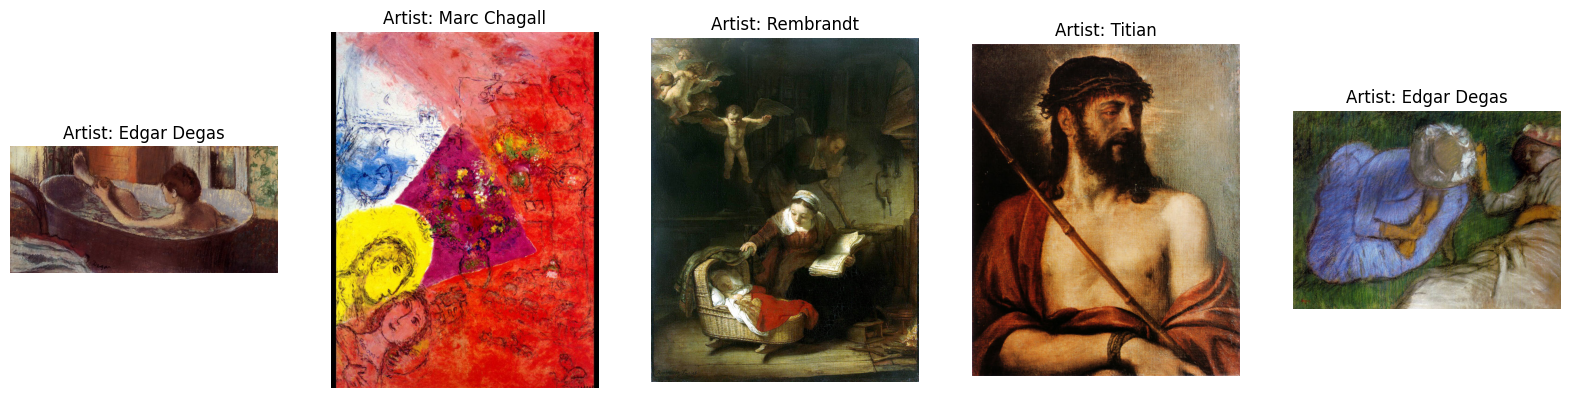

In [6]:
# Print few random paintings
n = 5
fig, axes = plt.subplots(1, n, figsize=(20,10))

for i in range(n):
    random_artist = random.choice(artist_names)
    random_image = random.choice(os.listdir(os.path.join(paintings_dir, random_artist)))
    random_image_file = os.path.join(paintings_dir, random_artist, random_image)
    image = plt.imread(random_image_file)
    axes[i].imshow(image)
    axes[i].set_title("Artist: " + random_artist.replace('_', ' '))
    axes[i].axis('off')

plt.show()

## Data Augmentation & Train-Test Split

In [7]:
# Directory paths
output_dir = "Data/processed_images"
train_dir = os.path.join(output_dir, 'train')
test_dir = os.path.join(output_dir, 'test')

# Create directories for train and test sets
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Prepare the data for splitting
file_paths = []
labels = []

for artist in artist_names:
    artist_folder = os.path.join(paintings_dir, artist)
    for img_file in os.listdir(artist_folder):
        file_paths.append(os.path.join(artist_folder, img_file))
        labels.append(artist)
            
# Split the data into train and test sets
train_paths, test_paths, train_labels, test_labels = train_test_split(
    file_paths, labels, test_size=0.2, stratify=labels, random_state=42)

# Move images to respective directories
def move_files(file_paths, labels, base_dir):
    for file_path, label in zip(file_paths, labels):
        dest_dir = os.path.join(base_dir, label)
        os.makedirs(dest_dir, exist_ok=True)
        dest_path = os.path.join(dest_dir, os.path.basename(file_path))
        if not os.path.exists(dest_path):
            shutil.copy(file_path, dest_path)

move_files(train_paths, train_labels, train_dir)
move_files(test_paths, test_labels, test_dir)

In [8]:
# Function to create data generator
def custom_datagen(is_train=True):
    if is_train:
        return ImageDataGenerator(
            rescale=1./255,
            rotation_range=30,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            vertical_flip=True,
            fill_mode='nearest'
        )
    else:
        return ImageDataGenerator(rescale=1./255)

# Data generators for training and validation
train_datagen = custom_datagen(is_train=True)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical'
)

test_datagen = custom_datagen(is_train=False)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical'
)

# Calculate steps per epoch and validation steps
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = test_generator.samples // test_generator.batch_size

print("Steps per epoch:", steps_per_epoch)
print("Validation steps:", validation_steps)

Found 3439 images belonging to 11 classes.
Found 860 images belonging to 11 classes.
Steps per epoch: 214
Validation steps: 53


## Random painting and it's augmented version

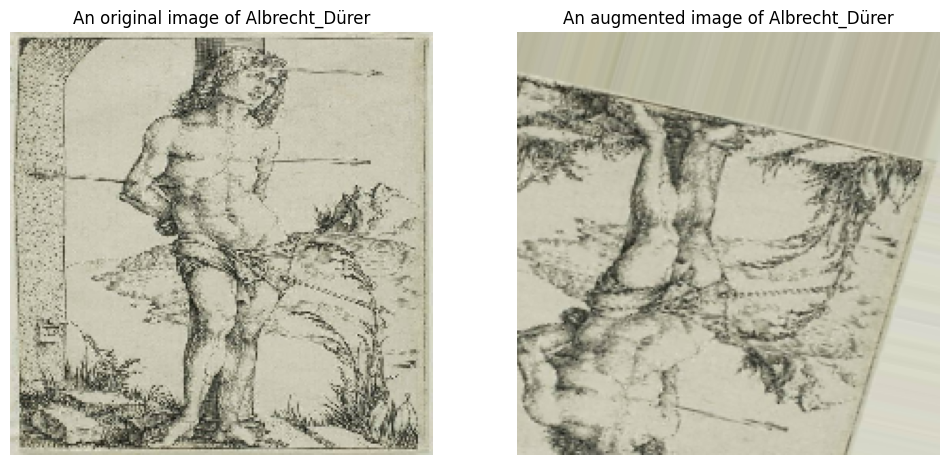

In [9]:
# Function to display images side by side
def display_images(original, augmented):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    # Display original image
    axes[0].imshow(original)
    axes[0].set_title("An original image of " + random_artist)
    axes[0].axis('off')
    
    # Display augmented image
    axes[1].imshow(augmented)
    axes[1].set_title("An augmented image of " + random_artist)
    axes[1].axis('off')
    
    plt.show()

# Get a random image from the training directory
random_artist = random.choice(os.listdir(train_dir))
artist_folder = os.path.join(train_dir, random_artist)
random_image_file = random.choice(os.listdir(artist_folder))
random_image_path = os.path.join(artist_folder, random_image_file)

# Load the image
original_image = load_img(random_image_path, target_size=(224, 224))

# Convert image to array and reshape
original_array = img_to_array(original_image)
original_array = original_array.reshape((1,) + original_array.shape)

# Generate augmented images
augmented_iter = train_datagen.flow(original_array, batch_size=1)

# Get the augmented image
augmented_image = next(augmented_iter)[0]

# Display the images
display_images(original_image, augmented_image)

## Build model

In [10]:
# Load ResNet50 model, excluding the top layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = True

In [11]:
# Add custom layers on top of ResNet50
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

# Define the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

## Train model

In [12]:
# Define early stopping and learning rate scheduler callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1, 
                           mode='auto', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, 
                              verbose=1, mode='auto')

In [13]:
# Training Round 1

history1 = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=test_generator,
    validation_steps=validation_steps,
    epochs=10,
    class_weight=artists_df["class_weights"].to_dict(),
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/10


c:\Users\olami\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


214/214 ━━━━━━━━━━━━━━━━━━━━ 1035s 5s/step - accuracy: 0.2800 - loss: 2.5985 - val_accuracy: 0.0542 - val_loss: 30.2530 - learning_rate: 1.0000e-04
Epoch 2/10
  1/214 ━━━━━━━━━━━━━━━━━━━━ 16:24 5s/step - accuracy: 0.6250 - loss: 1.4574

c:\Users\olami\AppData\Local\Programs\Python\Python310\lib\contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


214/214 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.6250 - loss: 1.4574 - val_accuracy: 0.1667 - val_loss: 26.4792 - learning_rate: 1.0000e-04
Epoch 3/10
214/214 ━━━━━━━━━━━━━━━━━━━━ 1057s 5s/step - accuracy: 0.5954 - loss: 1.4143 - val_accuracy: 0.0401 - val_loss: 8.1261 - learning_rate: 1.0000e-04
Epoch 4/10
214/214 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5625 - loss: 1.6160 - val_accuracy: 0.0000e+00 - val_loss: 9.3566 - learning_rate: 1.0000e-04
Epoch 5/10
214/214 ━━━━━━━━━━━━━━━━━━━━ 1036s 5s/step - accuracy: 0.6699 - loss: 1.1443 - val_accuracy: 0.1120 - val_loss: 4.1248 - learning_rate: 1.0000e-04
Epoch 6/10
214/214 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6875 - loss: 1.2804 - val_accuracy: 0.1667 - val_loss: 4.4304 - learning_rate: 1.0000e-04
Epoch 7/10
214/214 ━━━━━━━━━━━━━━━━━━━━ 1025s 5s/step - accuracy: 0.7579 - loss: 0.9273 - val_accuracy: 0.3042 - val_loss: 4.2055 - learning_rate: 1.0000e-04
Epoch 8/10
214/214 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 

In [14]:
# Training Round 2

# Freeze all layers
for layer in model.layers:
    layer.trainable = False

# Unfreeze the top layers
num_layers_to_unfreeze = 50

for layer in model.layers[-num_layers_to_unfreeze:]:
    layer.trainable = True
    
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

n_epoch = 50

history2 = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=test_generator,
    validation_steps=validation_steps,
    epochs=n_epoch,
    shuffle=True,
    verbose=1,
    callbacks=[reduce_lr, early_stop],
    class_weight=artists_df["class_weights"].to_dict()
)

Epoch 1/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 450s 2s/step - accuracy: 0.7990 - loss: 0.7651 - val_accuracy: 0.7535 - val_loss: 1.0091 - learning_rate: 1.0000e-04
Epoch 2/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9375 - loss: 0.2868 - val_accuracy: 0.8333 - val_loss: 0.7589 - learning_rate: 1.0000e-04
Epoch 3/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 441s 2s/step - accuracy: 0.8183 - loss: 0.6474 - val_accuracy: 0.7205 - val_loss: 1.2777 - learning_rate: 1.0000e-04
Epoch 4/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8125 - loss: 0.9855 - val_accuracy: 0.6667 - val_loss: 1.5337 - learning_rate: 1.0000e-04
Epoch 5/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 432s 2s/step - accuracy: 0.8373 - loss: 0.5944 - val_accuracy: 0.7736 - val_loss: 0.8628 - learning_rate: 1.0000e-04
Epoch 6/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8125 - loss: 0.7131 - val_accuracy: 0.5833 - val_loss: 1.0006 - learning_rate: 1.0000e-04
Epoch 7/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 439s 2s/step - accura

In [15]:
# Training Round 3

# Freeze all layers
for layer in model.layers:
    layer.trainable = False

# Unfreeze the top layers
num_layers_to_unfreeze = 20

for layer in model.layers[-num_layers_to_unfreeze:]:
    layer.trainable = True
    
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

n_epoch = 50

history3 = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=test_generator,
    validation_steps=validation_steps,
    epochs=n_epoch,
    shuffle=True,
    verbose=1,
    callbacks=[reduce_lr, early_stop],
    class_weight=artists_df["class_weights"].to_dict()
)

Epoch 1/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 361s 2s/step - accuracy: 0.9715 - loss: 0.1037 - val_accuracy: 0.8396 - val_loss: 0.8330 - learning_rate: 1.0000e-04
Epoch 2/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 1.0000 - loss: 3.6096e-04 - val_accuracy: 0.8333 - val_loss: 0.9747 - learning_rate: 1.0000e-04
Epoch 3/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 348s 2s/step - accuracy: 0.9643 - loss: 0.1171 - val_accuracy: 0.8196 - val_loss: 0.9392 - learning_rate: 1.0000e-04
Epoch 4/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8750 - loss: 0.7609 - val_accuracy: 0.8333 - val_loss: 1.1325 - learning_rate: 1.0000e-04
Epoch 5/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 350s 2s/step - accuracy: 0.9611 - loss: 0.1203 - val_accuracy: 0.8396 - val_loss: 0.8781 - learning_rate: 1.0000e-04
Epoch 6/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 1.0000 - loss: 0.0035 - val_accuracy: 1.0000 - val_loss: 0.0671 - learning_rate: 1.0000e-04
Epoch 7/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 355s 2s/step - ac

In [16]:
# Save the model
model.save('art_attribution_model.h5')

## Training Graph

In [17]:
# Merge history1, history2, and history3
training_history = {}
training_history['loss'] = history1.history['loss'] + history2.history['loss'] + history3.history['loss']
training_history['acc'] = history1.history['accuracy'] + history2.history['accuracy'] + history3.history['accuracy']
training_history['val_loss'] = history1.history['val_loss'] + history2.history['val_loss'] + history3.history['val_loss']
training_history['val_acc'] = history1.history['val_accuracy'] + history2.history['val_accuracy'] + history3.history['val_accuracy']
training_history['lr'] = history1.history['learning_rate'] + history2.history['learning_rate'] + history3.history['learning_rate']

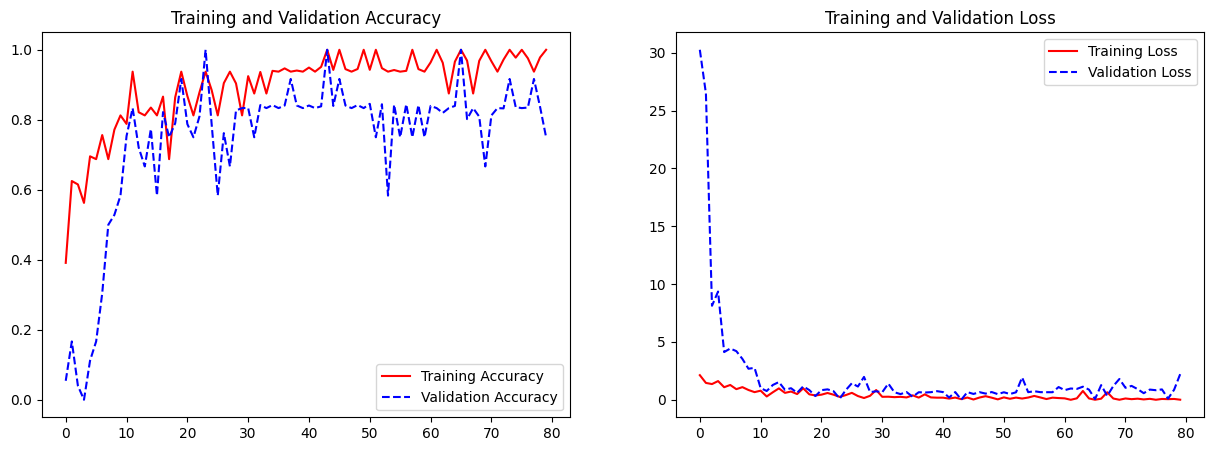

In [18]:
# Plot the training graph
def plot_training(training_history):
    acc = training_history['acc']
    val_acc = training_history['val_acc']
    loss = training_history['loss']
    val_loss = training_history['val_loss']
    epochs = range(len(acc))

    fig, axes = plt.subplots(1, 2, figsize=(15,5))
    
    axes[0].plot(epochs, acc, 'r-', label='Training Accuracy')
    axes[0].plot(epochs, val_acc, 'b--', label='Validation Accuracy')
    axes[0].set_title('Training and Validation Accuracy')
    axes[0].legend(loc='best')

    axes[1].plot(epochs, loss, 'r-', label='Training Loss')
    axes[1].plot(epochs, val_loss, 'b--', label='Validation Loss')
    axes[1].set_title('Training and Validation Loss')
    axes[1].legend(loc='best')
    
    plt.show()
    
plot_training(training_history)

## Evaluate Performance

In [19]:
# Prediction accuracy on train data
score = model.evaluate(train_generator, verbose=1)
print("Prediction accuracy on train data =", score[1])

215/215 ━━━━━━━━━━━━━━━━━━━━ 257s 1s/step - accuracy: 0.9824 - loss: 0.0518
Prediction accuracy on train data = 0.9802268147468567


In [20]:
# Prediction accuracy on CV data
score = model.evaluate(test_generator, verbose=1)
print("Prediction accuracy on CV data =", score[1])

54/54 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.8322 - loss: 0.8519
Prediction accuracy on CV data = 0.8395348787307739


## Confusion Matrix - What artists does the model consider as similar?

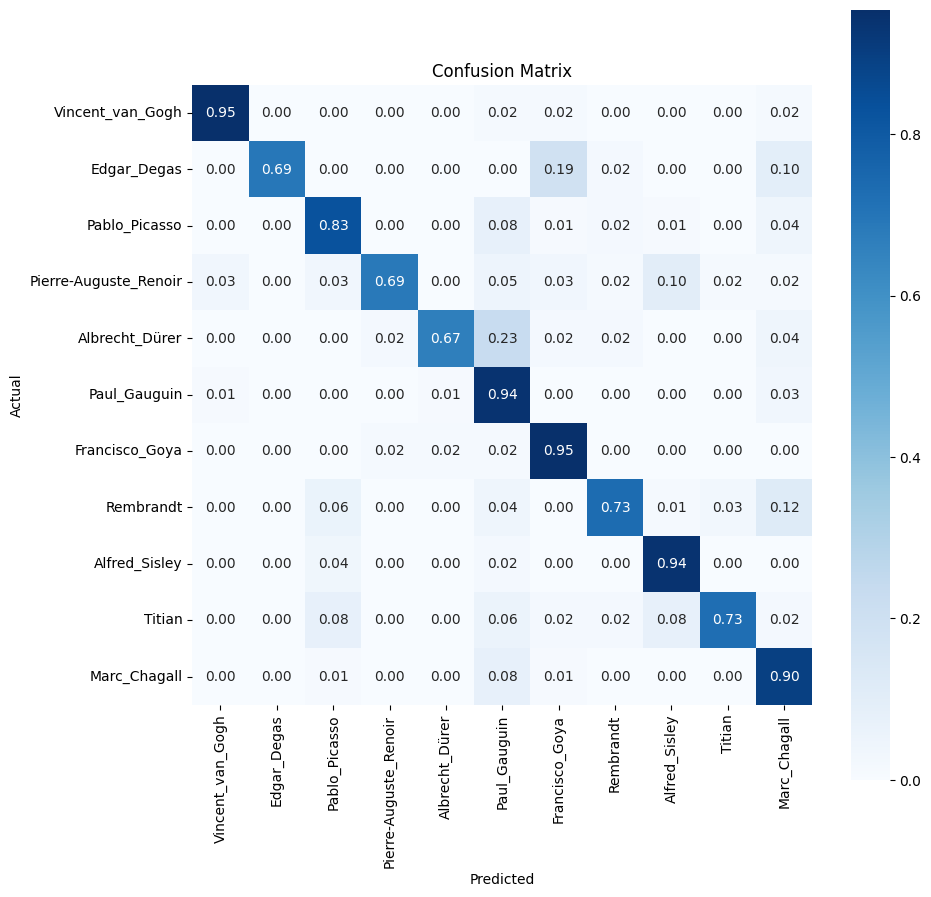

Classification Report:
                       precision    recall  f1-score   support

     Vincent_van_Gogh       0.95      0.95      0.95        66
          Edgar_Degas       1.00      0.69      0.82        52
        Pablo_Picasso       0.89      0.83      0.86       140
Pierre-Auguste_Renoir       0.95      0.69      0.80        58
       Albrecht_Dürer       0.94      0.67      0.78        48
         Paul_Gauguin       0.63      0.94      0.76        88
       Francisco_Goya       0.76      0.95      0.84        62
            Rembrandt       0.88      0.73      0.80        67
        Alfred_Sisley       0.79      0.94      0.86        52
               Titian       0.93      0.73      0.81        51
         Marc_Chagall       0.85      0.90      0.88       176

             accuracy                           0.84       860
            macro avg       0.87      0.82      0.83       860
         weighted avg       0.86      0.84      0.84       860



In [22]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Define tick labels and number of classes
tick_labels = artist_names.tolist()
n_classes = len(tick_labels)

def show_classification_report_generator(model, test_generator, validation_steps):
    y_pred, y_true = [], []
    for _ in range(validation_steps):
        x, y = next(test_generator)
        preds = model.predict(x, verbose=0)  # Suppress progress bar
        y_pred.extend(preds)
        y_true.extend(y)
    
    # Convert lists to numpy arrays
    y_pred = np.array(y_pred)
    y_true = np.array(y_true)
    
    # Get the class with the highest probability
    y_true = np.argmax(y_true, axis=1)
    y_pred = np.argmax(y_pred, axis=1)
    
    # Generate confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred, labels=np.arange(n_classes))
    
    # Normalize the confusion matrix
    conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
    
    # Plot the confusion matrix
    fig, ax = plt.subplots(figsize=(10, 10))
    sns.heatmap(conf_matrix_normalized, annot=True, fmt=".2f", square=True, cbar=True,
                cmap=plt.cm.Blues, xticklabels=tick_labels, yticklabels=tick_labels, ax=ax)
    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')
    ax.set_title('Confusion Matrix')
    plt.show()
    
    # Print classification report
    print('Classification Report:')
    print(classification_report(y_true, y_pred, target_names=tick_labels))

# Ensure validation steps are correctly set
validation_steps = len(test_generator)

# Call the function
show_classification_report_generator(model, test_generator, validation_steps)

## Examples - Predicting on random images from the dataset

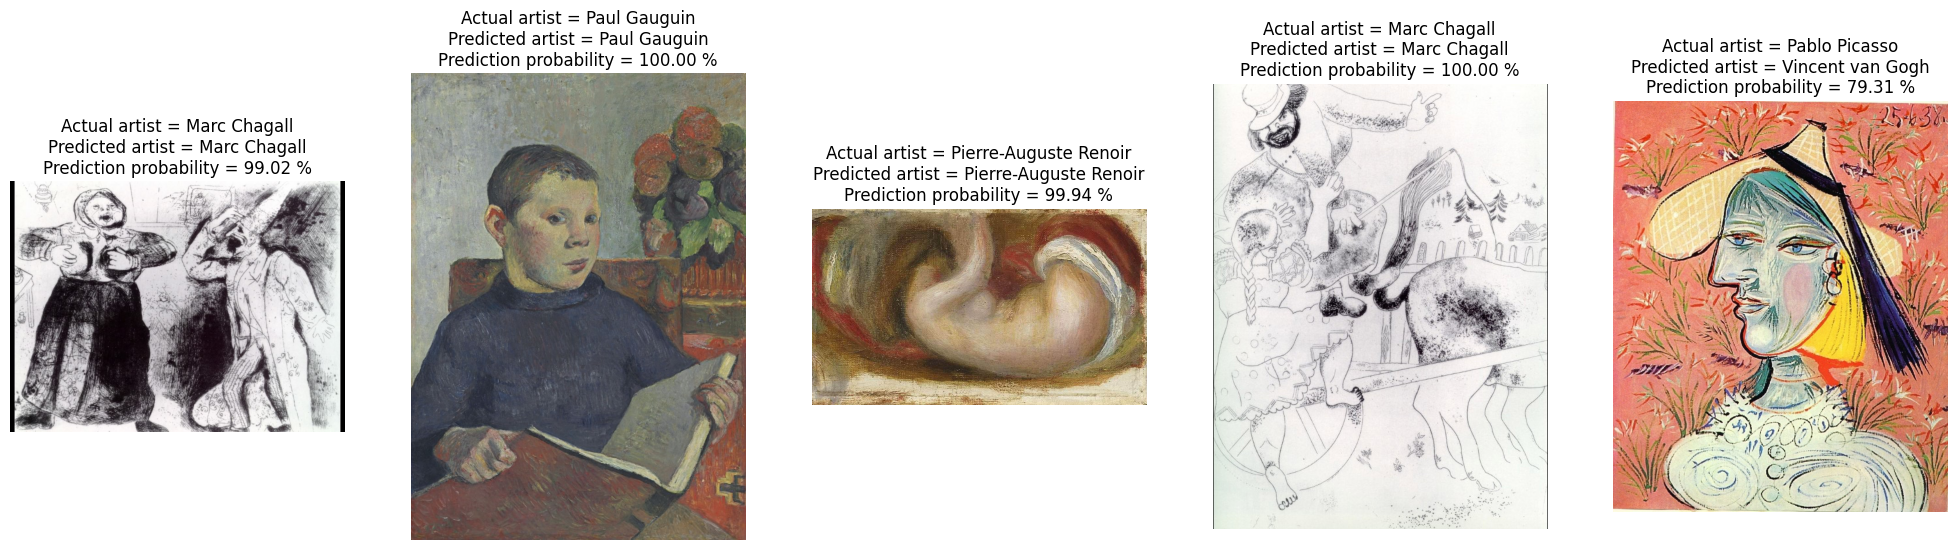

In [26]:
# Prediction
n = 5
fig, axes = plt.subplots(1, n, figsize=(25,10))
    
for i in range(n):
    random_artist = random.choice(artist_names)
    random_image = random.choice(os.listdir(os.path.join(paintings_dir, random_artist)))
    random_image_file = os.path.join(paintings_dir, random_artist, random_image)

    # Original image
    test_image = load_img(random_image_file, target_size=(224, 224))

    # Predict artist
    test_image = img_to_array(test_image)
    test_image /= 255.
    test_image = np.expand_dims(test_image, axis=0)

    prediction = model.predict(test_image, verbose=0)
    prediction_probability = np.amax(prediction)
    prediction_idx = np.argmax(prediction)

    labels = train_generator.class_indices
    labels = dict((v,k) for k,v in labels.items())

    title = f"Actual artist = {random_artist.replace('_', ' ')}\n" \
            f"Predicted artist = {labels[prediction_idx].replace('_', ' ')}\n" \
            f"Prediction probability = {prediction_probability * 100:.2f} %"

    # Display the image
    axes[i].imshow(load_img(random_image_file))
    axes[i].set_title(title)
    axes[i].axis('off')

plt.show()

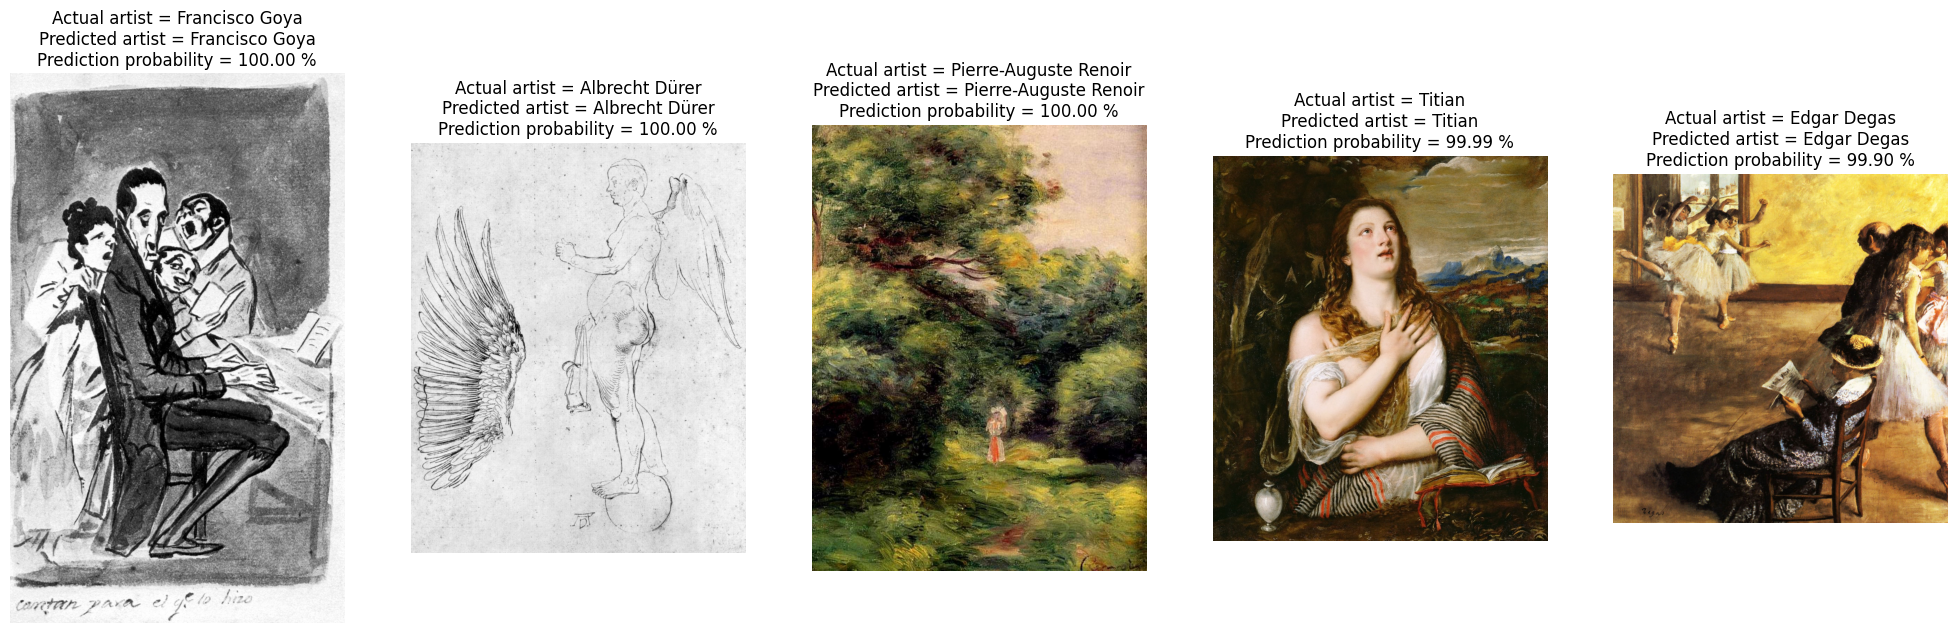

In [27]:
# Prediction
n = 5
fig, axes = plt.subplots(1, n, figsize=(25,10))
    
for i in range(n):
    random_artist = random.choice(artist_names)
    random_image = random.choice(os.listdir(os.path.join(paintings_dir, random_artist)))
    random_image_file = os.path.join(paintings_dir, random_artist, random_image)

    # Original image
    test_image = load_img(random_image_file, target_size=(224, 224))

    # Predict artist
    test_image = img_to_array(test_image)
    test_image /= 255.
    test_image = np.expand_dims(test_image, axis=0)

    prediction = model.predict(test_image, verbose=0)
    prediction_probability = np.amax(prediction)
    prediction_idx = np.argmax(prediction)

    labels = train_generator.class_indices
    labels = dict((v,k) for k,v in labels.items())

    title = f"Actual artist = {random_artist.replace('_', ' ')}\n" \
            f"Predicted artist = {labels[prediction_idx].replace('_', ' ')}\n" \
            f"Prediction probability = {prediction_probability * 100:.2f} %"

    # Display the image
    axes[i].imshow(load_img(random_image_file))
    axes[i].set_title(title)
    axes[i].axis('off')

plt.show()

## More Examples - Images from the internet

Actual artist = Titian
Predicted artist = Titian
Prediction probability = 94.86342072486877 %


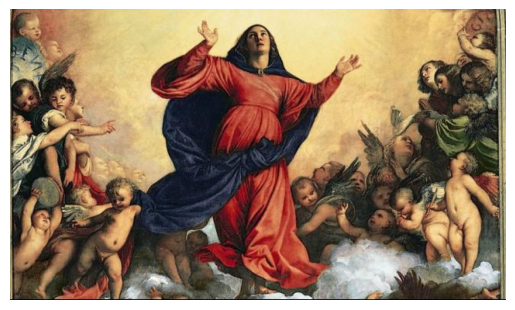

In [30]:
# Predict from web - this is an image of Titian's "Assumption of The Virgin".
# Replace 'url' with any image of one of the 11 artists above and run this cell.

import imageio.v2 as imageio
import cv2

# Define the URL of the image
url = 'https://www.gpsmycity.com/img/gd/2081.jpg'

# Load the image from the web
web_image = imageio.imread(url)

# Resize the image
web_image = cv2.resize(web_image, dsize=(224, 224))

# Preprocess the image
web_image = img_to_array(web_image)
web_image /= 255.0
web_image = np.expand_dims(web_image, axis=0)

# Predict the artist
prediction = model.predict(web_image, verbose=0)
prediction_probability = np.amax(prediction)
prediction_idx = np.argmax(prediction)

# Update the labels dictionary
labels = train_generator.class_indices
labels = dict((v, k) for k, v in labels.items())

# Print the predicted artist and prediction probability
print("Actual artist = Titian")
print("Predicted artist =", labels[prediction_idx].replace('_', ' '))
print("Prediction probability =", prediction_probability * 100, "%")

# Display the image
plt.imshow(imageio.imread(url))
plt.axis('off')
plt.show()


Actual artist = Vincent van Gogh
Predicted artist = Vincent van Gogh
Prediction probability = 96.97260856628418 %


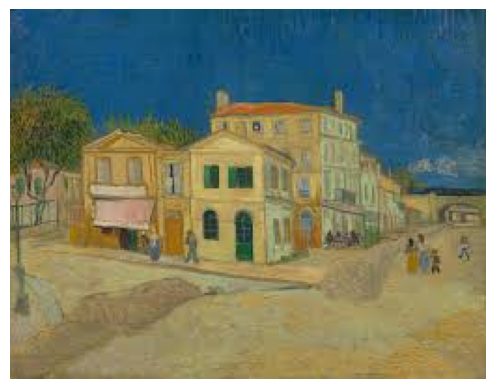

In [31]:
# Predict from web - this is an image of van Gogh's "The Yellow House".
# Replace 'url' with any image of one of the 11 artists above and run this cell.

import imageio.v2 as imageio
import cv2

# Define the URL of the image
url = 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRQzMfvA1MOxKkS2gBY3EGqdZBsTFv841U8zw&s'

# Load the image from the web
web_image = imageio.imread(url)

# Resize the image
web_image = cv2.resize(web_image, dsize=(224, 224))

# Preprocess the image
web_image = img_to_array(web_image)
web_image /= 255.0
web_image = np.expand_dims(web_image, axis=0)

# Predict the artist
prediction = model.predict(web_image, verbose=0)
prediction_probability = np.amax(prediction)
prediction_idx = np.argmax(prediction)

# Update the labels dictionary
labels = train_generator.class_indices
labels = dict((v, k) for k, v in labels.items())

# Print the predicted artist and prediction probability
print("Actual artist = Vincent van Gogh")
print("Predicted artist =", labels[prediction_idx].replace('_', ' '))
print("Prediction probability =", prediction_probability * 100, "%")

# Display the image
plt.imshow(imageio.imread(url))
plt.axis('off')
plt.show()


Actual artist = Edgar Degas
Predicted artist = Edgar Degas
Prediction probability = 99.99568462371826 %


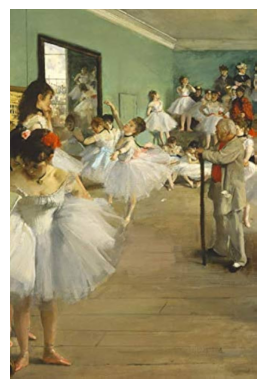

In [32]:
# Predict from web - this is an image of Degas' "The Ballet Class".
# Replace 'url' with any image of one of the 11 artists above and run this cell.

import imageio.v2 as imageio
import cv2

# Define the URL of the image
url = 'https://m.media-amazon.com/images/I/41Nqp9XXmRL._AC_UF1000,1000_QL80_.jpg'

# Load the image from the web
web_image = imageio.imread(url)

# Resize the image
web_image = cv2.resize(web_image, dsize=(224, 224))

# Preprocess the image
web_image = img_to_array(web_image)
web_image /= 255.0
web_image = np.expand_dims(web_image, axis=0)

# Predict the artist
prediction = model.predict(web_image, verbose=0)
prediction_probability = np.amax(prediction)
prediction_idx = np.argmax(prediction)

# Update the labels dictionary
labels = train_generator.class_indices
labels = dict((v, k) for k, v in labels.items())

# Print the predicted artist and prediction probability
print("Actual artist = Edgar Degas")
print("Predicted artist =", labels[prediction_idx].replace('_', ' '))
print("Prediction probability =", prediction_probability * 100, "%")

# Display the image
plt.imshow(imageio.imread(url))
plt.axis('off')
plt.show()


Actual artist = Edgar Degas
Predicted artist = Edgar Degas
Prediction probability = 87.73999810218811 %


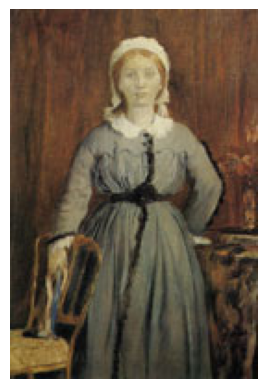

In [33]:
# Predict from web - this is an image of Degas' "Marguerite de Gas".
# Replace 'url' with any image of one of the 11 artists above and run this cell.

import imageio.v2 as imageio
import cv2

# Define the URL of the image
url = 'https://www.pubhist.com/works/46/thumb/degas_marguerite_de_gas.jpg'

# Load the image from the web
web_image = imageio.imread(url)

# Resize the image
web_image = cv2.resize(web_image, dsize=(224, 224))

# Preprocess the image
web_image = img_to_array(web_image)
web_image /= 255.0
web_image = np.expand_dims(web_image, axis=0)

# Predict the artist
prediction = model.predict(web_image, verbose=0)
prediction_probability = np.amax(prediction)
prediction_idx = np.argmax(prediction)

# Update the labels dictionary
labels = train_generator.class_indices
labels = dict((v, k) for k, v in labels.items())

# Print the predicted artist and prediction probability
print("Actual artist = Edgar Degas")
print("Predicted artist =", labels[prediction_idx].replace('_', ' '))
print("Prediction probability =", prediction_probability * 100, "%")

# Display the image
plt.imshow(imageio.imread(url))
plt.axis('off')
plt.show()


Actual artist = Albrecht Dürer
Predicted artist = Albrecht Dürer
Prediction probability = 100.0 %


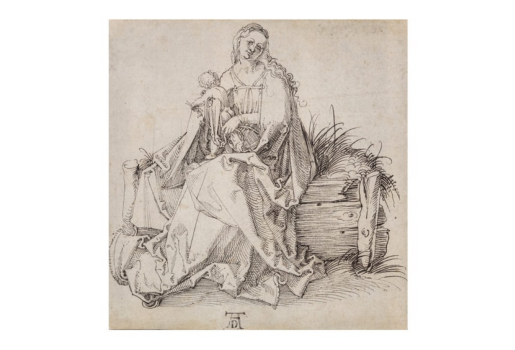

In [34]:
# Predict from web - this is an image of Durer's "The Virgin and Child with a Flower on a Grassy Bank".
# Replace 'url' with any image of one of the 11 artists above and run this cell.

import imageio.v2 as imageio
import cv2

# Define the URL of the image
url = 'https://image-cdn.hypb.st/https%3A%2F%2Fhypebeast.com%2Fimage%2F2021%2F11%2Fman-buys-albrecht-durer-drawing-estate-sale-1.jpg?cbr=1&q=90'

# Load the image from the web
web_image = imageio.imread(url)

# Resize the image
web_image = cv2.resize(web_image, dsize=(224, 224))

# Preprocess the image
web_image = img_to_array(web_image)
web_image /= 255.0
web_image = np.expand_dims(web_image, axis=0)

# Predict the artist
prediction = model.predict(web_image, verbose=0)
prediction_probability = np.amax(prediction)
prediction_idx = np.argmax(prediction)

# Update the labels dictionary
labels = train_generator.class_indices
labels = dict((v, k) for k, v in labels.items())

# Print the predicted artist and prediction probability
print("Actual artist = Albrecht Dürer")
print("Predicted artist =", labels[prediction_idx].replace('_', ' '))
print("Prediction probability =", prediction_probability * 100, "%")

# Display the image
plt.imshow(imageio.imread(url))
plt.axis('off')
plt.show()


Actual artist = AI imitating Renoir
Predicted artist = Pierre-Auguste Renoir
Prediction probability = 95.34008502960205 %


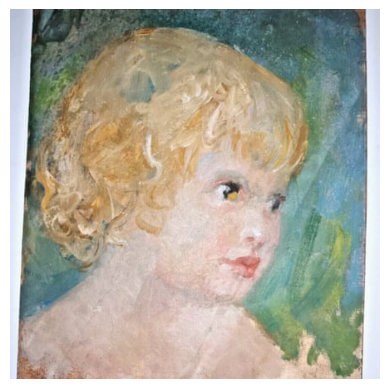

In [35]:
# Predict from web - this is an AI generated image in Renoir's style.
# Replace 'url' with any image of one of the 11 artists above and run this cell.

import imageio.v2 as imageio
import cv2

# Define the URL of the image
url = 'https://i.guim.co.uk/img/media/bab51fc95d7a769a836f72e9b5abc77a7a78f168/0_94_1089_1089/master/1089.jpg?width=445&dpr=1&s=none'

# Load the image from the web
web_image = imageio.imread(url)

# Resize the image
web_image = cv2.resize(web_image, dsize=(224, 224))

# Preprocess the image
web_image = img_to_array(web_image)
web_image /= 255.0
web_image = np.expand_dims(web_image, axis=0)

# Predict the artist
prediction = model.predict(web_image, verbose=0)
prediction_probability = np.amax(prediction)
prediction_idx = np.argmax(prediction)

# Update the labels dictionary
labels = train_generator.class_indices
labels = dict((v, k) for k, v in labels.items())

# Print the predicted artist and prediction probability
print("Actual artist = AI imitating Renoir")
print("Predicted artist =", labels[prediction_idx].replace('_', ' '))
print("Prediction probability =", prediction_probability * 100, "%")

# Display the image
plt.imshow(imageio.imread(url))
plt.axis('off')
plt.show()


Actual artist = AI imitating Picasso
Predicted artist = Pablo Picasso
Prediction probability = 100.0 %


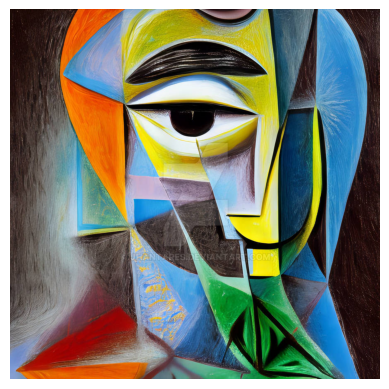

In [36]:
# Predict from web - this is an AI generated image in Picasso's style.
# Replace 'url' with any image of one of the 11 artists above and run this cell.

import imageio.v2 as imageio
import cv2

# Define the URL of the image
url = 'https://images-wixmp-ed30a86b8c4ca887773594c2.wixmp.com/f/e7507d71-eb9c-4cac-90b3-19dd71dc8bb6/dfo6p1d-49cf4ed4-6732-4681-a631-bb12047f7031.jpg/v1/fill/w_894,h_894,q_70,strp/picasso_style___ai_generated_by_jhantares_dfo6p1d-pre.jpg?token=eyJ0eXAiOiJKV1QiLCJhbGciOiJIUzI1NiJ9.eyJzdWIiOiJ1cm46YXBwOjdlMGQxODg5ODIyNjQzNzNhNWYwZDQxNWVhMGQyNmUwIiwiaXNzIjoidXJuOmFwcDo3ZTBkMTg4OTgyMjY0MzczYTVmMGQ0MTVlYTBkMjZlMCIsIm9iaiI6W1t7InBhdGgiOiJcL2ZcL2U3NTA3ZDcxLWViOWMtNGNhYy05MGIzLTE5ZGQ3MWRjOGJiNlwvZGZvNnAxZC00OWNmNGVkNC02NzMyLTQ2ODEtYTYzMS1iYjEyMDQ3ZjcwMzEuanBnIiwiaGVpZ2h0IjoiPD0xMDI0Iiwid2lkdGgiOiI8PTEwMjQifV1dLCJhdWQiOlsidXJuOnNlcnZpY2U6aW1hZ2Uud2F0ZXJtYXJrIl0sIndtayI6eyJwYXRoIjoiXC93bVwvZTc1MDdkNzEtZWI5Yy00Y2FjLTkwYjMtMTlkZDcxZGM4YmI2XC9qaGFudGFyZXMtNC5wbmciLCJvcGFjaXR5Ijo5NSwicHJvcG9ydGlvbnMiOjAuNDUsImdyYXZpdHkiOiJjZW50ZXIifX0.yJwbMXl6ajq9lozMjJZw-vwnbCL4EPMmjUaan-q_oeE'

# Load the image from the web
web_image = imageio.imread(url)

# Resize the image
web_image = cv2.resize(web_image, dsize=(224, 224))

# Preprocess the image
web_image = img_to_array(web_image)
web_image /= 255.0
web_image = np.expand_dims(web_image, axis=0)

# Predict the artist
prediction = model.predict(web_image, verbose=0)
prediction_probability = np.amax(prediction)
prediction_idx = np.argmax(prediction)

# Update the labels dictionary
labels = train_generator.class_indices
labels = dict((v, k) for k, v in labels.items())

# Print the predicted artist and prediction probability
print("Actual artist = AI imitating Picasso")
print("Predicted artist =", labels[prediction_idx].replace('_', ' '))
print("Prediction probability =", prediction_probability * 100, "%")

# Display the image
plt.imshow(imageio.imread(url))
plt.axis('off')
plt.show()


Actual artist = Some random kid
Predicted artist = Vincent van Gogh
Prediction probability = 64.56236839294434 %


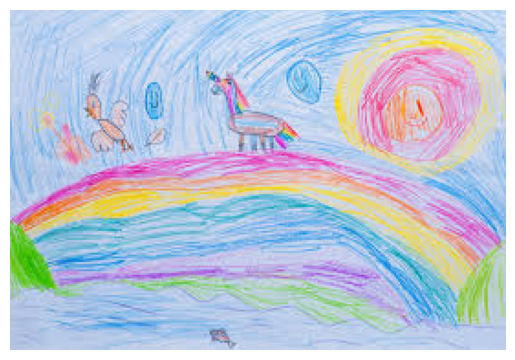

In [37]:
# Predict from web - this is an painting by a child.
# Replace 'url' with any image of one of the 11 artists above and run this cell.

import imageio.v2 as imageio
import cv2

# Define the URL of the image
url = 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQeUSKayoIArArXL4LB5-K7B-3h-fwqGiKovw&s'

# Load the image from the web
web_image = imageio.imread(url)

# Resize the image
web_image = cv2.resize(web_image, dsize=(224, 224))

# Preprocess the image
web_image = img_to_array(web_image)
web_image /= 255.0
web_image = np.expand_dims(web_image, axis=0)

# Predict the artist
prediction = model.predict(web_image, verbose=0)
prediction_probability = np.amax(prediction)
prediction_idx = np.argmax(prediction)

# Update the labels dictionary
labels = train_generator.class_indices
labels = dict((v, k) for k, v in labels.items())

# Print the predicted artist and prediction probability
print("Actual artist = Some random kid")
print("Predicted artist =", labels[prediction_idx].replace('_', ' '))
print("Prediction probability =", prediction_probability * 100, "%")

# Display the image
plt.imshow(imageio.imread(url))
plt.axis('off')
plt.show()
